# LIBS Analysis

In [1]:
# auto reload external packages
%load_ext autoreload
%autoreload 2

In [2]:
# import dependencies
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from plotly.offline import iplot, init_notebook_mode
import plotly.tools as tls
import plotly.graph_objs as go

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import seaborn as sns

init_notebook_mode(connected=True)

In [3]:
# raw_reading: single reading (corrupted or not, it is unknown)
# reading: subsampled or averaged multiple raw_readings - probably more noise free

# {BASEPATH}/{sample_path}/{raw_readings}.csv

# sample_path : one path of sample of soils (adana, samsun, etc.) - ex:{BASEPATH}/{labno}
# raw_reading_path : one path reading of one sample of soils (adana, samsun, etc.) - ex:{BASEPATH}/{labno}/{unix_rtime}.csv

BASEPATH = "samples"
LOCATION = "adana" # adana, samsun, nigde, yozgat

MAX_NM = 604.
MIN_NM = 247.8
NUM_DATAPOINTS = 4096


TICK_PERIOD = (MAX_NM-MIN_NM)/NUM_DATAPOINTS
SAMPLE_PATHS = list(Path(BASEPATH).glob('*'))

In [4]:
# create and save .png file for all readings per sample
def subplot25(sample_readings_paths):
    fig, axes = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(30,10))
    for ix, sample_path in enumerate(sample_readings_paths):
        df = pd.read_csv(sample_path)
        ax = axes[ix//5,ix%5]
        ax.plot(df['wavelengths'], df['intensities'], )
        ax.set_title(sample_path.name)
    fig.suptitle(sample_path.parent.name)
    image_save_path = sample_path.parent
    plt.savefig(image_save_path / 'readings.png')
    
    
# Call it
# for sample_path in SAMPLE_PATHS:
#     raw_reading_paths = Path(sample_path).glob('*.csv') # filter csv files
#     # show and save figures
#     subplot25(raw_reading_paths)

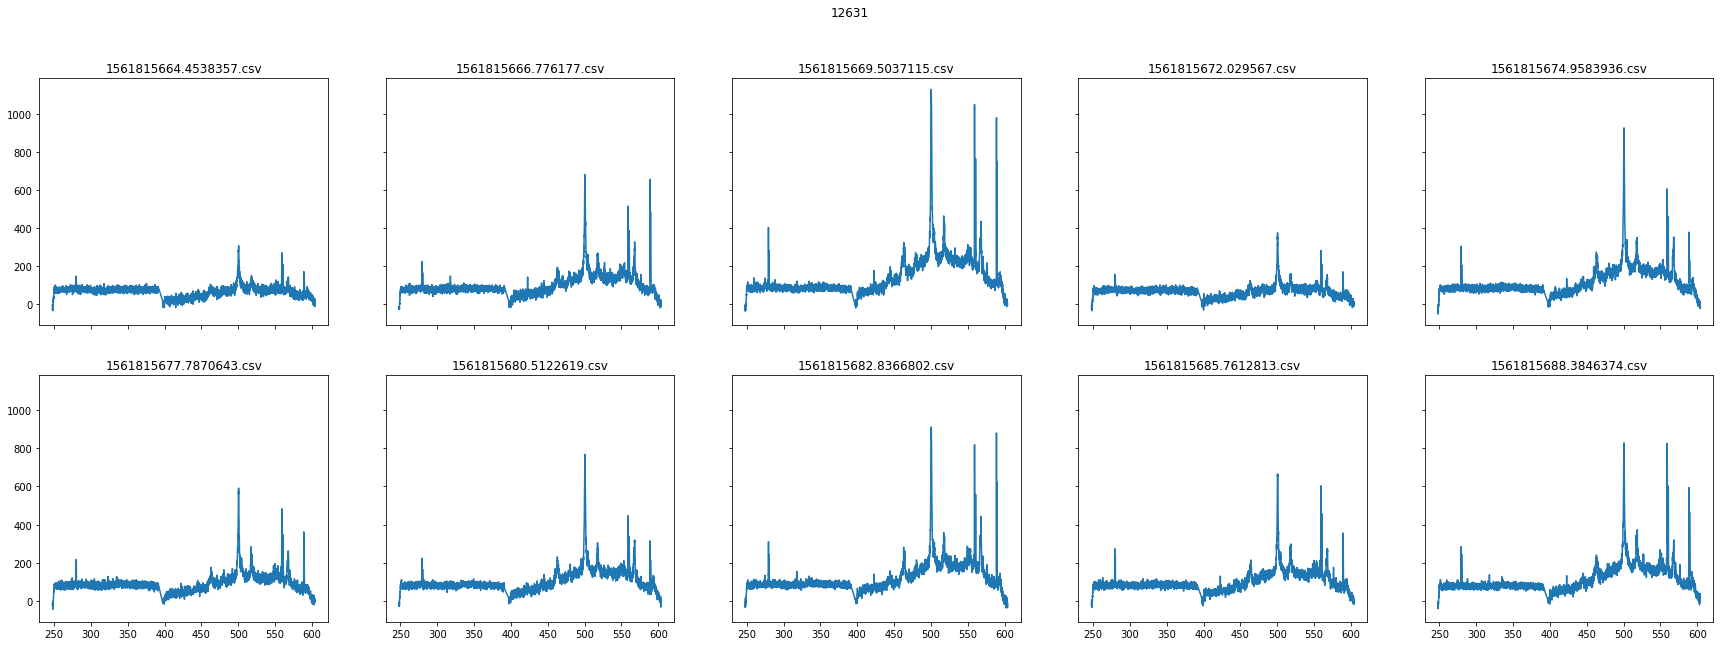

In [5]:
# 1 Sample of subplot25
raw_reading_paths = Path(SAMPLE_PATHS[0]).glob('*.csv')
subplot25(raw_reading_paths)

In [6]:
from functools import partial
from scipy import signal

class Sample:
    def __init__(self, sample_path):
        self.raw_readings = [pd.read_csv(raw_reading_path) 
                             for raw_reading_path in Path(sample_path).glob('*.csv')]
        
        # average samples
        self.reading = self.dataframes_average(self.raw_readings)
        # round sample
        self.reading = self.reading.round(3)
        self.plot = partial(self.subplot, [self.reading], 1, 1)
        
        self.reading = self.find_peaks(self.reading)
        self.sample_path = sample_path
        self.labno = int(sample_path.name)
    
    @staticmethod
    def find_peaks(reading, inplace=False):
        if not inplace:
            reading = reading.copy()
        
        peak_interval = 1.
        wavelengths = reading['wavelengths'].values
        intensities = reading['intensities'].values
        
        wavelengths_range = wavelengths.max() - wavelengths.min()
        sampling_interval = wavelengths_range / wavelengths.shape[0]

        peak_ixs = signal.argrelmax(intensities,
                                    order=int(peak_interval / sampling_interval))[0]
        
        reading['is_peak'] = False
        reading.loc[peak_ixs, 'is_peak'] = True
        return reading
    
    @staticmethod
    def get_reading_cond(intensities_above=200, is_peak=True):
        return s.reading.loc[(s.reading['intensities'] > intensities_above) & (s.reading['is_peak']==is_peak)]
        
        
    @staticmethod
    def subplot(readings, row, col):
        fig, axes = plt.subplots(row, col, sharex=True, sharey=True, squeeze=False)
        for ix, reading in enumerate(readings):
            axes[ix//col,ix%col if col!=1 else 0].plot(reading['wavelengths'], reading['intensities'])

    @staticmethod
    def plotly_plot(s):
        peak_df = s.reading.loc[s.reading['is_peak'] == True, :]
        trace_reading = go.Scatter(x=s.reading['wavelengths'], y=s.reading['intensities'], name='reading')
        trace_peak = go.Scatter(x=peak_df['wavelengths'], y=peak_df['intensities'], mode='markers', name='peaks')
        layout = go.Layout(
            xaxis=dict(
                range=[200, 700]
            ),
            yaxis=dict(
                range=[0, 2000]
            )
        )
        fig = go.Figure(data=[trace_reading, trace_peak], layout=layout)
        return fig
    
    
#     @staticmethod
#     def dataframes_round(dataframes):
#         r_dataframes = []
#         for df in dataframes:
#             r_dataframes += [df.round(2)]
#         return r_dataframes
    
    @staticmethod
    def dataframes_average(dataframes):
        avg_df = dataframes[0].copy()
        for df in dataframes[1:]:
            avg_df += df
        return avg_df / dataframes.__len__()
    
    def get_intensity_at(self, nm, error_margin=0.):
        intensities = self.reading.loc[(nm-error_margin < self.reading['wavelengths']) & 
                                (self.reading['wavelengths'] < nm+error_margin), 'intensities'].values
        if(intensities.shape[0] > 1):
            print(f'More than 1 intensities returned at {nm} +- {error_margin}')
        return intensities[0]

    def get_nearest_nm(self, nm, error_margin=0.):
        wavelengths = self.reading.loc[(nm-error_margin < self.reading['wavelengths']) & 
                            (self.reading['wavelengths'] < nm+error_margin), 'wavelengths'].values
        if(wavelengths.shape[0] > 1):
            print(f'More than 1 wavelengths returned at {nm} +- {error_margin}')
        return wavelengths[0]
    
    def is_peak_at(self, nm):
        return self.reading.loc[self.reading['wavelengths'] == nm, 'is_peak'].values[0] == True

        


# Azotu tekrarlananlar

In [7]:
SAMPLES = {sample_path.name:Sample(sample_path) for sample_path in SAMPLE_PATHS}

In [28]:
N_nms = [279.482,
         334.762,
         421.624,
         [443.506, 443.613],
         498.2, 
         498.9,
         499.9,
         500.540,
         501.6, 
         503.0,
         [589.024, 589.116]]

# 742.36 nm,
# 744,23
# 746,83



class Analysis:
    def __init__(self, sample_paths, location="Adana", excel_path="Azotu tekrarlananlar.xlsx"):
        self.location = location
        
        self.excel = pd.read_excel(excel_path)
        self.excel = self.excel.loc[self.excel['Valid']==1, :] # get only valid samples
        self.data = self.excel.loc[self.excel['Loc']==self.location].iloc[:, :5] # get location only && first 5 column
        
        self.samples = {sample_path.name:Sample(sample_path) for sample_path in sample_paths}
        self.samples = SAMPLES
        
        self.data = self.create_nm_columns(self.data.copy())
        self.data = self.insert_peak_values(self.data.copy(), self.samples)
        
        
        self.data = self.data.sort_values(by=['%Azot'])
        
    
    def plot(self):
        plot_df = self.data
        cols = plot_df.columns.values[5:]
                 
        data = [go.Scatter(x=plot_df['%Azot'], y=plot_df[col], 
                            name=col, mode='lines+markers') for col in cols]
  
        layout = go.Layout()
        fig = go.Figure(data=data)
        iplot(fig)
        
    def heatmap(self, x_col, y_col):
        plot_df = self.data.copy()
                 
        data = [go.Heatmap(x=plot_df[x_col], 
                           y=plot_df[y_col], 
                           z=plot_df['%Azot'], zsmooth='best', colorscale='viridis')]
  
        layout = go.Layout()
        fig = go.Figure(data=data)
        iplot(fig)
        
    def apply_PCA(self, n_components=3):
        feature_cols = self.data.columns[5:]
        data_subset = self.data[feature_cols].values
        pca = PCA(n_components=n_components)
        pca_result = pca.fit_transform(data_subset)
        
        pca_df = self.data.copy()
        pca_df['pca-one'] = pca_result[:,0]
        pca_df['pca-two'] = pca_result[:,1] 
        if n_components > 2:
            pca_df['pca-three'] = pca_result[:,2]
        print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
        
        
        plt.figure(figsize=(8,6))
        sns.scatterplot(
            x="pca-one", y="pca-two",
            hue="%Azot",
            palette=sns.color_palette("hls", 10),
            data=pca_df,
            legend="full",
            alpha=0.8
        )
        
        return pca_df
    
    def apply_tSNE(self, n_components=2):
        
        feature_cols = self.data.columns[5:]
        data_subset = self.data[feature_cols].values
        tsne = TSNE(n_components=n_components, verbose=1, perplexity=40, n_iter=300)
        tsne_results = tsne.fit_transform(data_subset)
        
        tsne_df = self.data.copy()
        tsne_df['tsne-2d-one'] = tsne_results[:,0]
        tsne_df['tsne-2d-two'] = tsne_results[:,1]
        
        plt.figure(figsize=(8,6))
        sns.scatterplot(
            x="tsne-2d-one", y="tsne-2d-two",
            hue="%Azot",
            palette=sns.color_palette("hls", 10),
            data=tsne_df,
            legend="full",
            alpha=0.8
        )
        
        return tsne_df
        
        
        
    def get_by_labno(self, labno, query='%Azot'):
        return self.data.loc[self.data['Lab no'] == labno, query].values[0]
    
    @staticmethod
    def create_nm_columns(df):
        for i, N_nm in enumerate(N_nms):
            peak_str = ''
            if isinstance(N_nm, (list,)):
                peak_str = '-'.join([f'N{i}@{eachnm}' for eachnm in N_nm])
            else:
                peak_str += f'N{i}@{N_nm}'

            df[peak_str] = np.nan
        return df

    @staticmethod
    def insert_peak_values(df, samples):
        for labno, sample in samples.items():
            for i, N_nm in enumerate(N_nms):
                peak_str = ''
                peak_value = 0.
                if isinstance(N_nm, (list,)):
                    peak_str = '-'.join([f'N{i}@{eachnm}' for eachnm in N_nm])
                    peak_value = sum([sample.get_intensity_at(eachnm, TICK_PERIOD/2) for eachnm in N_nm])
                else:
                    peak_str += f'N{i}@{N_nm}'
    #                 print(N_nm, sample.labno)
                    peak_value = sample.get_intensity_at(N_nm, TICK_PERIOD/2)

                df.loc[df['Lab no']==sample.labno, peak_str] = peak_value
        return df
        

In [29]:
analysis = Analysis(sample_paths=SAMPLE_PATHS, location='Adana')

In [25]:
# pca_df = analysis.apply_PCA(n_components=5)

In [26]:
# tsne_df = analysis.apply_tSNE(n_components=2)

In [30]:
analysis.data.head()

,Lab no,Loc,SampleNo,Valid,%Azot,N0@279.482,N1@334.762,N2@421.624,N3@443.506-N3@443.613,N4@498.2,N5@498.9,N6@499.9,N7@500.54,N8@501.6,N9@503.0,N10@589.024-N10@589.116
58,13070,Adana,45,1,0.06,200.787,85.743,46.654,199.424,174.714,215.036,400.967,550.083,295.202,190.979,387.292
52,13047,Adana,46,1,0.11,158.089,81.000,34.468,146.694,146.221,184.708,325.996,455.168,246.065,148.572,418.091
54,13053,Adana,29,1,0.16,155.394,83.254,25.274,109.383,122.773,157.980,295.787,393.234,213.270,130.568,286.421
40,12638,Adana,35,1,0.17,205.041,88.110,43.352,179.935,171.913,217.766,414.447,554.804,300.963,188.922,450.602
49,13039,Adana,32,1,0.17,155.150,80.127,26.045,151.334,121.706,148.891,264.297,347.454,192.615,127.908,389.858


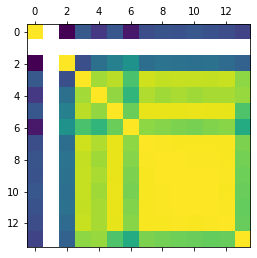

In [34]:
plt.matshow(analysis.data.corr())


In [35]:
corr = analysis.data.corr()
corr.style.background_gradient(cmap='coolwarm')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning:

invalid value encountered in less



,Lab no,Valid,%Azot,N0@279.482,N1@334.762,N2@421.624,N3@443.506-N3@443.613,N4@498.2,N5@498.9,N6@499.9,N7@500.54,N8@501.6,N9@503.0,N10@589.024-N10@589.116
Lab no,1,nan,-0.536177,-0.105659,-0.283677,-0.119485,-0.428692,-0.167066,-0.136907,-0.149664,-0.121612,-0.146373,-0.174403,-0.222237
Valid,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
%Azot,-0.536177,nan,1,-0.160764,0.0331428,0.133037,0.245943,0.0191402,0.0482148,0.0415829,0.0278175,0.0371919,0.00024355,-0.0509468
N0@279.482,-0.105659,nan,-0.160764,1,0.787254,0.841923,0.55639,0.8894,0.860179,0.862764,0.865991,0.85702,0.873747,0.737859
N1@334.762,-0.283677,nan,0.0331428,0.787254,1,0.749963,0.473241,0.818635,0.782565,0.802642,0.783793,0.801416,0.796812,0.765235
N2@421.624,-0.119485,nan,0.133037,0.841923,0.749963,1,0.656001,0.947617,0.946671,0.951586,0.957277,0.950118,0.94173,0.574507
N3@443.506-N3@443.613,-0.428692,nan,0.245943,0.55639,0.473241,0.656001,1,0.739403,0.723098,0.697862,0.683831,0.706741,0.724475,0.411588
N4@498.2,-0.167066,nan,0.0191402,0.8894,0.818635,0.947617,0.739403,1,0.989607,0.9879,0.986674,0.987566,0.986127,0.6959
N5@498.9,-0.136907,nan,0.0482148,0.860179,0.782565,0.946671,0.723098,0.989607,1,0.994739,0.99298,0.99228,0.983175,0.676187
N6@499.9,-0.149664,nan,0.0415829,0.862764,0.802642,0.951586,0.697862,0.9879,0.994739,1,0.997245,0.996108,0.98912,0.659108


In [56]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [62]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()

0.7466297012266012


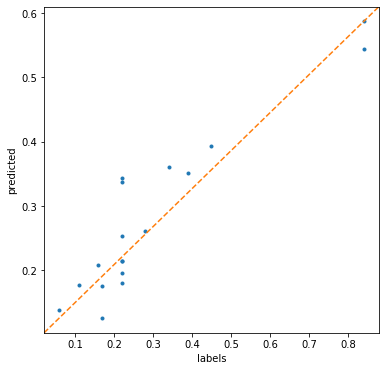

In [64]:
features = analysis.data.iloc[:, 5:].values
labels = analysis.data['%Azot'].values

model.fit(features, labels)
predicted = model.predict(features)
print(model.score(features, labels))

f, ax = plt.subplots(figsize=(6, 6))
ax.set_xlabel('labels')
ax.set_ylabel('predicted')
ax.plot(labels, predicted, '.')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--")

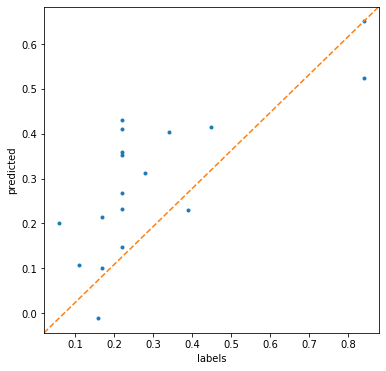